# Analyzing Orange Telecoms Customer Churn Dataset

Predicting which customer is likely to cancel subscription to a service. It has become a common practise across banks, ISPs, insurance firms and credit card companies.

### Run `Apache pyspark` from the terminal:
Load `pyspark` with the [Spark-CSV](http://spark-packages.org/package/databricks/spark-csv) package.

> IPYTHON_OPTS="notebook" ~/path_to_pyspark --packages com.databricks:spark-csv_2.11:1.4.0

In [3]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import plotly.plotly as py
import cufflinks as cf

## Fetching and Importing Churn Dataset
For this tutorial, we'll be using the Orange Telecoms Churn Dataset. It consists of cleaned customer activity data (features), along with a churn label specifying whether the customer canceled their subscription or not. The data can be fetched from BigML's S3 bucket, [churn-80](https://bml-data.s3.amazonaws.com/churn-bigml-80.csv) and [churn-20](https://bml-data.s3.amazonaws.com/churn-bigml-20.csv). The two sets are from the same batch, but have been split by an 80/20 ratio. We'll use the larger set for training and cross-validation purposes, and the smaller set for final testing and model performance evaluation. The two data sets have been included in this repository for convenience.

In [4]:
# Import dataset with spark CSV package
orange_sprk_df = sqlContext.read.load("../_datasets_downloads/churn-bigml-80.csv",
                                format='com.databricks.spark.csv',
                                header='true',
                                inferschema='true')

orange_final_dataset = sqlContext.read.load("../_datasets_downloads/churn-bigml-20.csv",
                                format='com.databricks.spark.csv',
                                header='true',
                                inferschema='true')

# Print Dataframe Schema. That's DataFrame = Dataset[Row]
orange_sprk_df.cache()
orange_sprk_df.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



In [3]:
# Display first 5 Rows or Spark Dataset
orange_sprk_df.toPandas().head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Summary Statistics
Show the summary statistic for the dataset. The describe function compute statistics ONLY for columns having numeric data types. So we can extract the numeric indexes from the resulting pandas dataframe.

In [5]:
num_set = orange_sprk_df.describe().toPandas().transpose()
num_set.head()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Account length,2666,100.62040510127532,39.56397365334986,1,243
Area code,2666,437.43885971492875,42.52101801942723,408,510
Number vmail messages,2666,8.021755438859715,13.612277018291945,0,50
Total day minutes,2666,179.48162040510107,54.21035022086984,0.0,350.8


In [5]:
# Display the numeric index
num_set.index.values

array(['summary', 'Account length', 'Area code', 'Number vmail messages',
       'Total day minutes', 'Total day calls', 'Total day charge',
       'Total eve minutes', 'Total eve calls', 'Total eve charge',
       'Total night minutes', 'Total night calls', 'Total night charge',
       'Total intl minutes', 'Total intl calls', 'Total intl charge',
       'Customer service calls'], dtype=object)

In [7]:
# Drop the `summary` and `Area code` columns and slice the dataframe using the numeric index.
new_df = orange_sprk_df.toPandas()
new_df = new_df[num_set.index.drop(['summary','Area code'])]
new_df.head()

,Account length,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


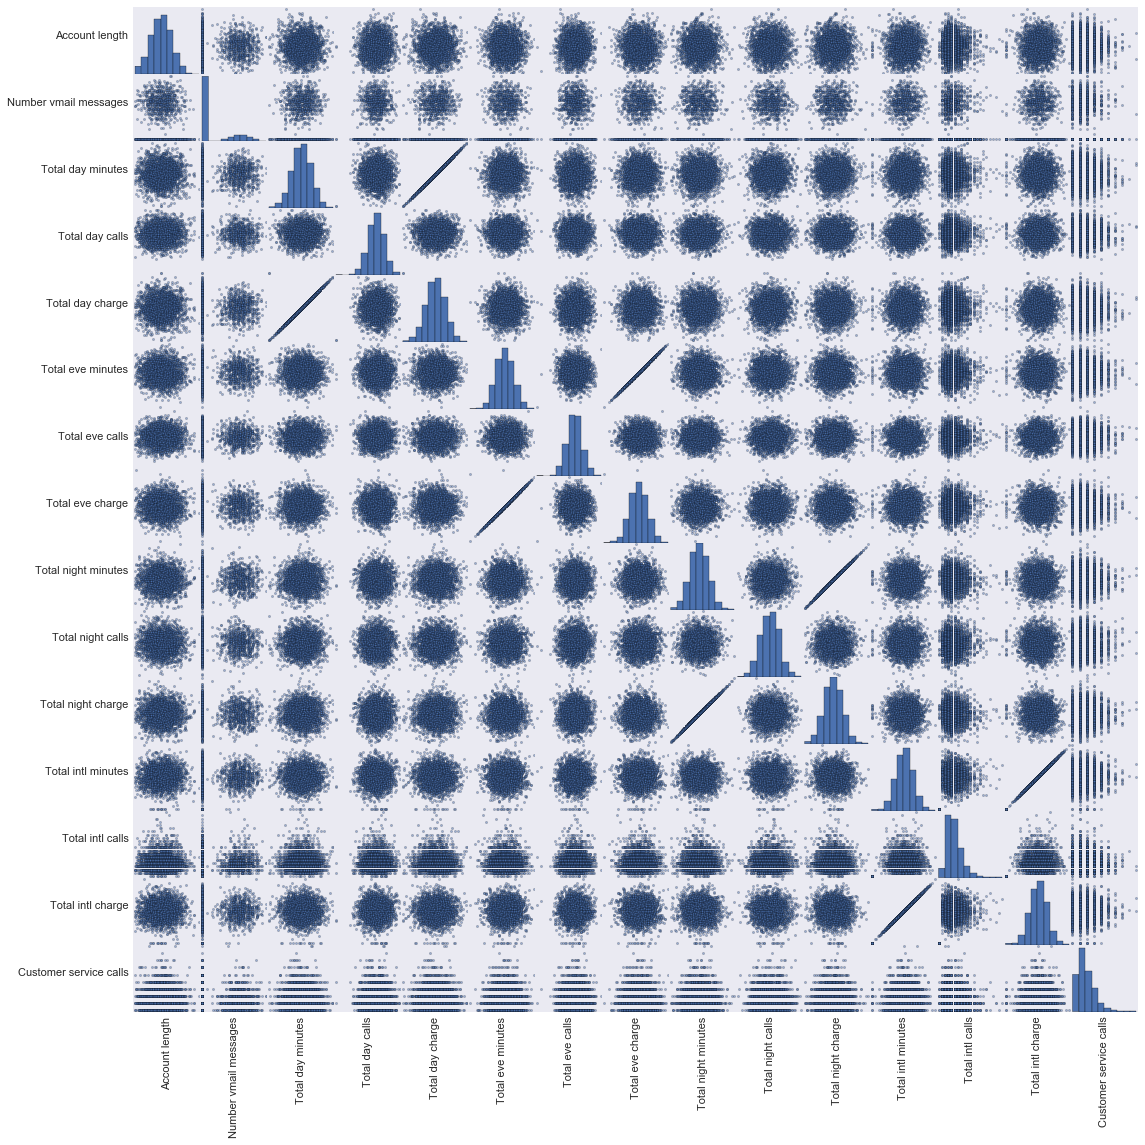

In [11]:
axs = pd.scatter_matrix(new_df, figsize=(18,18))

# Rotate axis labels and remove axis ticks
n = len(new_df.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())
    

Several of the numerical data are very correlated. (**`Total day minutes` and `Total day charge`**), (**`Total eve minutes` and `Total eve charge`**), (**`Total night minutes` and `Total night charge`**) and lastly (**`Total intl minutes` and `Total intl charge`**) are alo correlated. We only have to select one of them

In [14]:
binary_map = {'Yes':1.0, 'No':0.0, 'True':1.0, 'False':0.0}


# Remove correlated and unneccessary columns
col_to_drop = ['State', 'Area code', 'Total day charge', 'Total eve charge', 'Total night charge','Total intl charge']
orange_df = orange_sprk_df.toPandas().drop(col_to_drop, axis=1)

# Change categorical data to Numeric for the traininfg set 80%
orange_df[['International plan', 'Voice mail plan']] = orange_df[['International plan', 'Voice mail plan']].replace(binary_map)
orange_df['Churn'] = orange_df['Churn'].apply(lambda d: d.astype(float))


# Perform same function for the 20% test data
orange_train_df = orange_final_dataset.toPandas().drop(col_to_drop, axis=1)
orange_train_df[['International plan', 'Voice mail plan']] = orange_train_df[['International plan', 'Voice mail plan']].replace(binary_map)
orange_train_df['Churn'] = orange_train_df['Churn'].apply(lambda d: d.astype(float))

# Print sample
orange_df.head()


,Account length,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Churn
0,128,0.0,1.0,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0.0
1,107,0.0,1.0,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0.0
2,137,0.0,0.0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0.0
3,84,1.0,0.0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0.0
4,75,1.0,0.0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0.0


In [15]:
orange_2sparkdf = sqlContext.createDataFrame(orange_df)
orange_2sparkdf.take(2)



[Row(Account length=128, International plan=0.0, Voice mail plan=1.0, Number vmail messages=25, Total day minutes=265.1, Total day calls=110, Total eve minutes=197.4, Total eve calls=99, Total night minutes=244.7, Total night calls=91, Total intl minutes=10.0, Total intl calls=3, Customer service calls=1, Churn=0.0),
 Row(Account length=107, International plan=0.0, Voice mail plan=1.0, Number vmail messages=26, Total day minutes=161.6, Total day calls=123, Total eve minutes=195.5, Total eve calls=103, Total night minutes=254.4, Total night calls=103, Total intl minutes=13.7, Total intl calls=3, Customer service calls=1, Churn=0.0)]

# Spark Machine Learning Package `MLLib`

MLlib classifiers and regressors require data sets in a format of rows of type LabeledPoint, which separates row labels and feature lists, and names them accordingly. We split it further into training and testing sets. A decision tree classifier model is then generated using the training data, using a maxDepth of 2, to build a "shallow" tree. The tree depth can be regarded as an indicator of model complexity.

In [99]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.evaluation import MulticlassMetrics

In [64]:
# Separate the features and the target variable

def labelData(data):
    """
        LabeledPoint(self, label, features)
        Label: row[end] i.e. 'Churn'
        Features: row[0 : end-1] i.e. other columns beside last column
    """
    return data.map(lambda row: LabeledPoint(row[-1], row[:-1]))

# Example: Target Variable and Feature Variables.
labelData(orange_2sparkdf).takeSample(True, 5)


[LabeledPoint(0.0, [47.0,0.0,1.0,37.0,163.5,77.0,203.1,102.0,232.0,87.0,7.8,4.0,2.0]),
 LabeledPoint(1.0, [123.0,0.0,0.0,0.0,123.2,104.0,190.0,117.0,170.3,95.0,12.9,5.0,4.0]),
 LabeledPoint(1.0, [75.0,0.0,0.0,0.0,109.0,88.0,259.3,120.0,182.1,119.0,13.3,3.0,4.0]),
 LabeledPoint(0.0, [87.0,0.0,1.0,28.0,143.5,106.0,223.5,147.0,175.4,69.0,11.2,5.0,0.0]),
 LabeledPoint(0.0, [111.0,0.0,0.0,0.0,255.9,97.0,204.1,129.0,171.3,84.0,12.3,5.0,3.0])]

In [90]:
# Divide into training data and test data
training_data, testing_data = labelData(orange_2sparkdf).randomSplit([0.8, 0.2])

# Design the model
# Map categorical variables to number of into categories.
# index 1 `International plan` has 2 variables (Yes/No) and Index 2 'Voice mail plan' has 2 variables (Yes/No)
model = DecisionTree.trainClassifier(training_data, numClasses=2, 
                                     categoricalFeaturesInfo={1:2, 2:2}, 
                                     maxDepth=3, impurity='gini', maxBins=32
                                    )
print(model.toDebugString())

DecisionTreeModel classifier of depth 3 with 15 nodes
  If (feature 4 <= 263.4)
   If (feature 12 <= 3.0)
    If (feature 1 in {0.0})
     Predict: 0.0
    Else (feature 1 not in {0.0})
     Predict: 0.0
   Else (feature 12 > 3.0)
    If (feature 4 <= 179.8)
     Predict: 1.0
    Else (feature 4 > 179.8)
     Predict: 0.0
  Else (feature 4 > 263.4)
   If (feature 3 <= 0.0)
    If (feature 6 <= 187.4)
     Predict: 0.0
    Else (feature 6 > 187.4)
     Predict: 1.0
   Else (feature 3 > 0.0)
    If (feature 1 in {0.0})
     Predict: 0.0
    Else (feature 1 not in {0.0})
     Predict: 1.0



The toDebugString() function provides a print of the tree's decision nodes and final prediction outcomes at the end leafs. We can see that features 12 and 4 are used for decision making and should thus be considered as having high predictive power to determine a customer's likeliness to churn. It's not surprising that these feature numbers map to the fields Customer service calls and Total day minutes. Decision trees are often used for feature selection because they provide an automated mechanism for determining the most important features (those closest to the tree root).

In [98]:
print(orange_df.columns[4])
print(orange_df.columns[12])
print(orange_df.columns[6])
print(orange_df.columns[1])

Total day minutes
Customer service calls
Total eve minutes
International plan


## Model Evaluation

Predictions of the testing data's churn outcome are made with the model's `predict()` function and grouped together with the actual churn label of each customer data using `getPredictionsLabels()`.

We'll use MLlib's `MulticlassMetrics()` for the model evaluation, which takes rows of *(prediction, label)* tuples as input. It provides metrics such as `precision, recall, F1 score and confusion matrix`, which have been bundled for printing with the custom `printMetrics()` function.

In [100]:
def getPredictionLabels(model, testing_data):
    predictions = model.predict(testing_data.map(lambda r: r.features))
    return predictions.zip(testing_data.map(lambda r: r.label))


In [144]:
def printMetrics(predictions_and_labels):
    metrics = MulticlassMetrics(predictions_and_labels)
    print('Precision of True ', metrics.precision(1))
    print('Precision of False', metrics.precision(0))
    print('Recall of True / False Positive  ', metrics.recall(1))
    print('Recall of False / False Negative  ', metrics.recall(0))
    print('F-1 Score        \n\n ', metrics.fMeasure())
    print(pd.DataFrame([['True Positive','False Negative'],['False Positive','True Negative']]))
    print('\nConfusion Matrix \n\n {}'.format(metrics.confusionMatrix().toArray()))
    

In [142]:
predictions_and_labels = getPredictionLabels(model, testing_data)
predictions_and_labels.take(5)

[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)]

In [145]:
printMetrics(predictions_and_labels)

('Precision of True ', 0.8)
('Precision of False', 0.9154013015184381)
('Recall of True / False Positive  ', 0.417910447761194)
('Recall of False / False Negative  ', 0.9836829836829837)
('F-1 Score        \n\n ', 0.907258064516129)
                0               1
0   True Positive  False Negative
1  False Positive   True Negative

Confusion Matrix 

 [[ 422.    7.]
 [  39.   28.]]


The `F-1 Score` is $90.7%$ however the `recall measures` or `sensitivity` have high discrepancy. Perhaps the model's sensitivity bias toward `Churn=False` samples is due to a skewed distribution of the two types of samples. Let's try grouping the `orange_2sparkdf` DataFrame by the Churn field and counting the number of instances in each group.

In [147]:
orange_2sparkdf.groupBy('Churn').count().toPandas()

,Churn,count
0,1.0,388
1,0.0,2278


## Stratified sampling 
A probability sampling technique where the entire data/population is divided into different subgroups or strata, then randomly selects the final subjects proportionally from the different strata. The `False` samples are almost **7 times** larger than the `True` samples so the distribution is skewed. We can build a new model using an evenly distributed data set.

In [174]:
# Sample all the 1s (100% of ones) amd 20% of zeros.
strat_orange_2sparkdf = orange_2sparkdf.sampleBy('Churn', fractions={0:0.2, 1:1.0})
strat_orange_2sparkdf.groupBy('Churn').count().toPandas()

,Churn,count
0,1.0,388
1,0.0,477


In [175]:
training_data, testing_data = labelData(strat_orange_2sparkdf).randomSplit([0.8, 0.2])

model = DecisionTree.trainClassifier(training_data, numClasses=2, 
                                     categoricalFeaturesInfo={1:2, 2:2}, 
                                     maxDepth=3, impurity='gini', maxBins=32 )

predictions_and_labels = getPredictionLabels(model, testing_data)
printMetrics(predictions_and_labels)

('Precision of True ', 0.7948717948717948)
('Precision of False', 0.7857142857142857)
('Recall of True / False Positive  ', 0.7469879518072289)
('Recall of False / False Negative  ', 0.8279569892473119)
('F-1 Score        \n\n ', 0.7897727272727273)
                0               1
0   True Positive  False Negative
1  False Positive   True Negative

Confusion Matrix 

 [[ 77.  16.]
 [ 21.  62.]]


With these new recall values, we see that the stratified data built a less biased model, which will ultimately provide more generalized and robust predictions. 